In [2]:
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import seaborn as sns
from scipy.signal import butter,filtfilt,welch
from scipy import signal
import optuna
import numpy as np  
import optuna.visualization as vis
from optuna.pruners import MedianPruner

import plotly

/usr/lib/python3/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
low_cutoff = 0.01  # Low cut-off frequency (Hz)
high_cutoff = 70.0  # High cut-off frequency (Hz)
order = 4  # Order of the filter
sampling_rate_equipo= 500 
b, a = signal.butter(order, [low_cutoff / (0.5 * sampling_rate_equipo), high_cutoff / (0.5 * sampling_rate_equipo)], btype='band')

In [4]:

fs = 500  # Sampling rate
nperseg = 256  # Segment length
noverlap = 128 # Overlap between segments
sampling_rate = 2000 ### simulacion 

resultado_compilacion = subprocess.run("g++ -fopenmp -O3 main.cpp Matrix_conect.cpp -o main_multi", shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
if resultado_compilacion.returncode != 0:
    print("Error durante la compilación:")
    print(resultado_compilacion.stderr)

def Simulado_EGG(params):
    L, P, inhibidoras, trest, trelative, alpha, tmax, type_matrix = params
        
    # Ejecución del programa
    resultado_ejecucion = subprocess.run(f"./main_multi {L} {P} {inhibidoras} {trest} {trelative} {alpha} {tmax} {type_matrix}", shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    if resultado_ejecucion.returncode != 0:
        print("Error durante la ejecución:")
        print(resultado_ejecucion.stderr)
        return None
    
    # Procesamiento de los datos
    lines = resultado_ejecucion.stdout.strip().split('\n')
    data_list = [[float(num) for num in line.split()] for line in lines]
    data = np.array(data_list)[30:,1]

    
    #data=(data-np.mean(data)) /np.std(data)
    data=data/np.max(data) 
    n_samples_resampled = int(len(data) * (fs/sampling_rate))
    data_resampled = signal.resample(data, n_samples_resampled)

    butter = signal.filtfilt(b, a,data_resampled)

    frequencies, psd = signal.welch(butter, fs, nperseg=nperseg, noverlap=noverlap)
    frequencies=np.array(frequencies)


    welch_data = np.array([10 * np.log10(psd[i]) for i in range(len(frequencies))])
    
    delta = welch_data[np.logical_and(frequencies >= 0, frequencies <= 3)]
    theta = welch_data[np.logical_and(frequencies >= 3, frequencies <= 7)]
    alpha = welch_data[np.logical_and(frequencies >= 7, frequencies <= 14)]
    beta = welch_data[np.logical_and(frequencies >= 14, frequencies <= 30)]

    return {
        'data': data,"data_resample":data_resampled,"butter": butter,
        "frequencies": frequencies,"welch_data":welch_data,
        'delta':[delta.mean(),delta.std()],
        'theta':[theta.mean(), theta.std()],
        'alpha':[ alpha.mean(),alpha.std()],
        'beta': [beta.mean(), beta.std()]
    }



# Datos Reales

 Tanto como los datos reales como lo simulados pueden ser normlaizados(por su maximo), los valores real estan en microvoltios, en la simulacion estan con 0.00070 microvoltios reposo 

In [5]:
def Datos_reales(nombres):
    Datos = np.empty(len(nombres), dtype=object)
    Butter = np.empty(len(nombres), dtype=object)
    welch_datos = np.empty(len(nombres), dtype=object)
    Frequencies = np.empty(len(nombres), dtype=object)
    Delta = np.empty(len(nombres), dtype=object)
    Theta = np.empty(len(nombres), dtype=object)
    Alpha = np.empty(len(nombres), dtype=object)
    Beta = np.empty(len(nombres), dtype=object)
    Nombres=np.empty(len(nombres), dtype="U100")

    # Inicialización de arrays para promedios de bandas
    main_Delta = np.zeros(2)
    main_Theta = np.zeros(2)
    main_Alpha = np.zeros(2)
    main_Beta = np.zeros(2)
    for i, nombre in enumerate(nombres):  
        Nombres[i]=nombre 



        data = np.loadtxt(nombre)
        
        #data=data/np.max(data)
        data=(data-np.mean(data)) /np.std(data)
        Datos[i]=data
        Butter[i]=butter= signal.filtfilt(b, a,data)

        frequencies, psd = signal.welch(butter, fs, nperseg=nperseg, noverlap=noverlap)
        Frequencies[i]=frequencies=np.array(frequencies)

        welch_data = np.array([10 * np.log10(psd[i]) for i in range(len(frequencies))])
        welch_datos[i]=welch_data

        delta = welch_data[np.logical_and(frequencies >= 1, frequencies <= 3)]
        theta = welch_data[np.logical_and(frequencies >= 4, frequencies <= 7)]
        alpha = welch_data[np.logical_and(frequencies >= 7, frequencies <= 13)]
        beta = welch_data[np.logical_and(frequencies >= 14, frequencies <= 30)]

        Delta[i]=[delta.mean(),delta.std()]
        Theta[i]=[theta.mean(),theta.std()]
        Alpha[i]=[alpha.mean(),alpha.std()]
        Beta[i]=[beta.mean(),beta.std()]

        main_Delta += np.array([delta.mean(), delta.std()]) / len(nombres)
        main_Theta += np.array([theta.mean(), theta.std()]) / len(nombres)
        main_Alpha += np.array([alpha.mean(), alpha.std()]) / len(nombres)
        main_Beta += np.array([beta.mean(), beta.std()]) / len(nombres)

    return {
        "Nombres":Nombres,
        'datos': Datos, "frequencies": Frequencies,  "welch_data":welch_datos,
        'delta':Delta,'theta':Theta,'alpha':Alpha,'beta':Beta,
        'main_Delta': main_Delta,'main_Theta':main_Theta,"main_Alpha":main_Alpha,"main_Beta":main_Beta
    }


In [6]:
Params={'L': 36, 'P': 0.9034507902546892, 'Inh': 0.40920754880440563, 'Trest': -3.979704188912379, 'Trelative': 2.7077017063223425, 'C_h': 14.282158626022971, 'Tipo_red': 2}

initial_params = [Params["L"], Params["P"],Params["Inh"], Params["Trest"],Params["Trelative"], Params["C_h"] ,8030, Params["Tipo_red"]]
generated_data = Simulado_EGG(initial_params)
reales_total = Datos_reales(["P3_MNE.txt","Pz_MNE.txt","P4_MNE.txt"])

['P3_MNE.txt' 'Pz_MNE.txt' 'P4_MNE.txt']


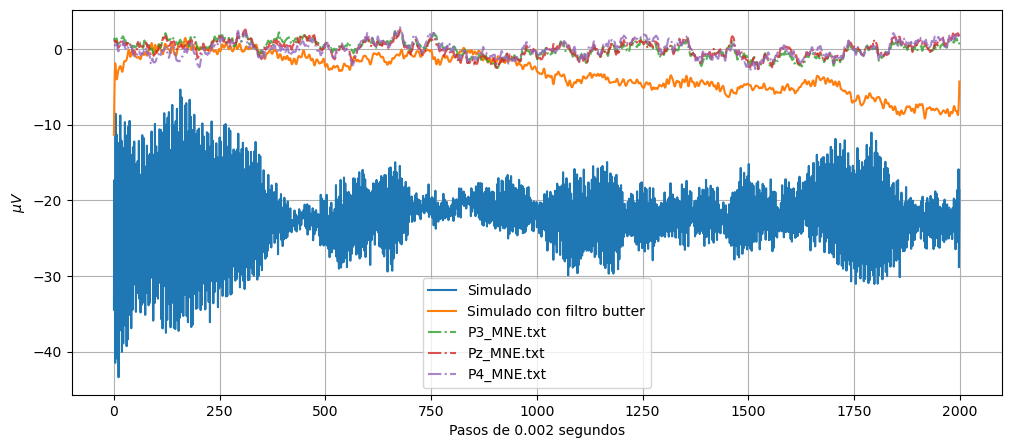

In [7]:
fig, ax = plt.subplots(figsize=[12, 5])

print(reales_total["Nombres"])
ax.plot(generated_data["data_resample"],label="Simulado")
ax.plot(generated_data["butter"],label="Simulado con filtro butter")
for i in range(3):
    ax.plot(reales_total["datos"][i],"-.", label=reales_total["Nombres"][i],alpha=0.8)


plt.xlabel("Pasos de 0.002 segundos")
plt.ylabel(r"$\mu V$")
plt.legend()  # Esto añade una leyenda para identificar cada línea
plt.grid()
plt.show()  # Mostrar todos los gráficos en la misma figura


[  0.         1.953125   3.90625    5.859375   7.8125     9.765625
  11.71875   13.671875  15.625     17.578125  19.53125   21.484375
  23.4375    25.390625  27.34375   29.296875  31.25      33.203125
  35.15625   37.109375  39.0625    41.015625  42.96875   44.921875
  46.875     48.828125  50.78125   52.734375  54.6875    56.640625
  58.59375   60.546875  62.5       64.453125  66.40625   68.359375
  70.3125    72.265625  74.21875   76.171875  78.125     80.078125
  82.03125   83.984375  85.9375    87.890625  89.84375   91.796875
  93.75      95.703125  97.65625   99.609375 101.5625   103.515625
 105.46875  107.421875 109.375    111.328125 113.28125  115.234375
 117.1875   119.140625 121.09375  123.046875 125.       126.953125
 128.90625  130.859375 132.8125   134.765625 136.71875  138.671875
 140.625    142.578125 144.53125  146.484375 148.4375   150.390625
 152.34375  154.296875 156.25     158.203125 160.15625  162.109375
 164.0625   166.015625 167.96875  169.921875 171.875    173.82

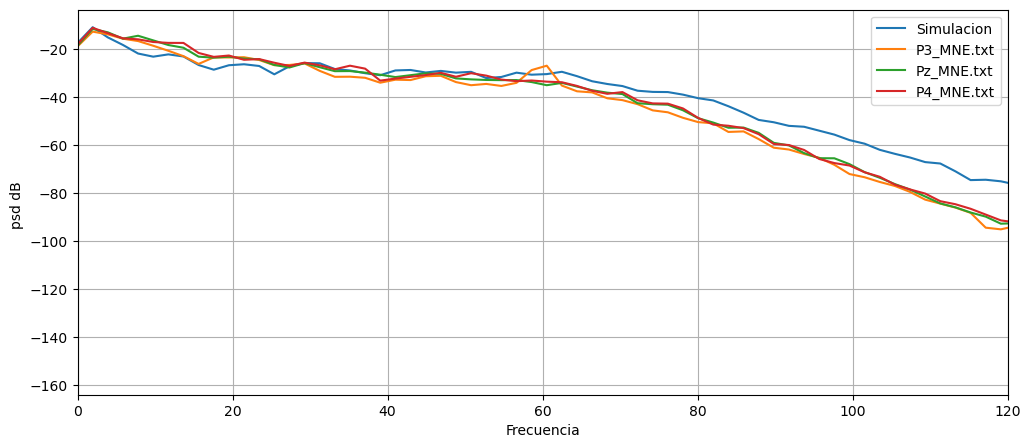

In [14]:
fig, ax = plt.subplots(figsize=[12, 5])
print(generated_data["frequencies"])
print(len(generated_data["frequencies"]))
print(len(reales_total["frequencies"][0]))
frequencies = reales_total["frequencies"][0]
count_in_range = np.sum((frequencies >= 0) & (frequencies <= 30))
print(count_in_range)

print(reales_total["Nombres"])
print("Delta",generated_data["delta"],"----",reales_total["main_Delta"])
print("Theta",generated_data["theta"],"----",reales_total["main_Theta"])
print("Alpha",generated_data["alpha"],"----",reales_total["main_Alpha"])
print("Beta",generated_data["beta"],"----",reales_total["main_Beta"])

ax.plot(generated_data["frequencies"],generated_data["welch_data"],label="Simulacion")
for i in range(3):
    ax.plot(reales_total["frequencies"][i],reales_total["welch_data"][i], label=reales_total["Nombres"][i])

plt.xlabel("Frecuencia")
plt.ylabel("psd dB ")
plt.grid()
plt.xlim(0,120)
plt.legend()  # Esto añade una leyenda para identificar cada línea
plt.show()  # Mostrar todos los gráficos en la misma figura


In [9]:

def objective(trial):
    params = np.zeros(8)
    params[0] = trial.suggest_int('L',25,35)
    params[1] = trial.suggest_float('P', 0.0, 1.0)
    params[2] = trial.suggest_float('Inh', 0.0, 1.0)
    params[3] = trial.suggest_float('Trest', -10.0, 10.0)###, step=0.05 difernecia entre datos 
    params[4] = trial.suggest_float('Trelative',params[3],params[3]+10)  
    params[5] = trial.suggest_float('C_h', 0, 50)
    params[6] = 8030
    params[7] = trial.suggest_int('Tipo_red',1,2)

    
    generated_data_total = Simulado_EGG(params)
    if generated_data_total["delta"][1]-generated_data_total["delta"][1]==0:
        dif_Delta=generated_data_total["delta"]-reales_total["main_Delta"]
        dif_Theta=generated_data_total["theta"]-reales_total["main_Theta"]
        dif_Alpha=generated_data_total["alpha"]-reales_total["main_Alpha"]
        dif_Beta=generated_data_total["beta"]-reales_total["main_Beta"]
        difference = (np.sum(np.abs(dif_Delta)) +
                            np.sum(np.abs(dif_Theta)) +
                            np.sum(np.abs(dif_Alpha)) +
                            np.sum(np.abs(dif_Beta)))

        trial.report(difference, step=trial.number)
        
        
        return difference
    else:
        return float('inf') 
    
# Create and optimize the study
study = optuna.create_study(study_name='4bandas_SW_max', 
                            storage='sqlite:///Estudios/small_world/4bandas_SW_max.db', 
                            load_if_exists=True,pruner=MedianPruner())

# Continúa con la optimización del estudio
study.optimize(objective, n_trials=1000)


[I 2024-10-13 19:22:33,067] Using an existing study with name '4bandas_SW_max' instead of creating a new one.
[I 2024-10-13 19:22:35,463] Trial 3680 finished with value: 57.96058178920178 and parameters: {'L': 27, 'P': 0.39717882833849083, 'Inh': 0.4694640658309267, 'Trest': -4.156040046868864, 'Trelative': 3.5444191100469276, 'C_h': 26.71153407478588, 'Tipo_red': 2}. Best is trial 2656 with value: 8.597448821266049.
[I 2024-10-13 19:22:36,717] Trial 3681 finished with value: 51.03913079759867 and parameters: {'L': 28, 'P': 0.42762119967388074, 'Inh': 0.4457934055882377, 'Trest': -4.557987669715249, 'Trelative': 3.3822352950830243, 'C_h': 24.327547051144382, 'Tipo_red': 2}. Best is trial 2656 with value: 8.597448821266049.
[I 2024-10-13 19:22:38,024] Trial 3682 finished with value: 35.88471650132938 and parameters: {'L': 28, 'P': 0.38295179610794017, 'Inh': 0.49401466625716633, 'Trest': -5.190940637253302, 'Trelative': 3.7388240924450518, 'C_h': 26.754379746856564, 'Tipo_red': 2}. Best

KeyboardInterrupt: 

In [9]:


def objective(trial):
    params = np.zeros(8)
    params[0] = trial.suggest_int('L', 10, 60)
    params[1] = trial.suggest_float('P', 0.0, 1.0)
    params[2] = trial.suggest_float('Inh', 0.0, 1.0)
    params[3] = trial.suggest_float('Trest', -10.0, 10.0)
    params[4] = trial.suggest_float('Trelative', params[3], params[3] + 10)
    params[5] = trial.suggest_float('C_h', 0, 10.0)
    params[6] = 8030
    params[7] = trial.suggest_int('Tipo_red', 0, 4)

    generated_data_total = Simulado_EGG(params)

    # Asegúrate de que no haya NaN en las diferencias
    if generated_data_total["delta"][1] - generated_data_total["delta"][1] == 0:
        dif_Delta = generated_data_total["delta"] - reales_total["main_Delta"]
        dif_Theta = generated_data_total["theta"] - reales_total["main_Theta"]
        dif_Alpha = generated_data_total["alpha"] - reales_total["main_Alpha"]
        dif_Beta = generated_data_total["beta"] - reales_total["main_Beta"]

        # Calcular las diferencias absolutas
        abs_dif_Delta = np.sum(np.abs(dif_Delta))
        abs_dif_Theta = np.sum(np.abs(dif_Theta))
        abs_dif_Alpha = np.sum(np.abs(dif_Alpha))
        abs_dif_Beta = np.sum(np.abs(dif_Beta))      

        # Retornar como una tupla
        return abs_dif_Delta, abs_dif_Theta, abs_dif_Alpha, abs_dif_Beta
         
    else:
        return float('inf'), float('inf'), float('inf'), float('inf')

# Crear y optimizar el estudio para múltiples objetivos
study = optuna.create_study(directions=["minimize", "minimize", "minimize", "minimize"],
                             study_name='4bandas_full_No_normal',
                             storage='sqlite:///Estudios_multi/4bandas_full_No_normal.db',
                             load_if_exists=True)

# Continúa con la optimización del estudio
study.optimize(objective, n_trials=500)


[I 2024-10-07 14:19:57,568] A new study created in RDB with name: 4bandas_full_No_normal
[I 2024-10-07 14:20:01,417] Trial 0 finished with values: [84.98090841390913, 76.97227103099594, 74.94707891764446, 76.34795010257024] and parameters: {'L': 27, 'P': 0.0871662280449883, 'Inh': 0.34109375787065166, 'Trest': -0.873256848425763, 'Trelative': 4.97014579732724, 'C_h': 8.799291919765777, 'Tipo_red': 4}. 
[I 2024-10-07 14:20:03,995] Trial 1 finished with values: [85.54761529845649, 81.04121555776472, 73.26813139549978, 67.39345032368776] and parameters: {'L': 36, 'P': 0.2487052499627822, 'Inh': 0.9732232142045479, 'Trest': -0.059297971337002764, 'Trelative': 7.644736181020938, 'C_h': 6.7949521109384605, 'Tipo_red': 1}. 
[I 2024-10-07 14:20:05,745] Trial 2 finished with values: [79.08514027978954, 66.08576850589644, 43.70701620173315, 24.045977656668615] and parameters: {'L': 28, 'P': 0.2831759371010347, 'Inh': 0.28430719809001437, 'Trest': -9.715408896693265, 'Trelative': -3.5220196199889

KeyboardInterrupt: 

In [37]:
# Imprimir el nombre del estudio
print(study.study_name)

# Filtrar los trials válidos
valid_trials = [t for t in study.trials if t.values is not None]

# Obtener los mejores trials en función de uno de los objetivos, por ejemplo, el primero
top_trials = sorted(valid_trials, key=lambda t: t.values[0])[:10]

# Imprimir los mejores trials
for i, trial in enumerate(top_trials):
    print(f"Trial {i}:")
    print(f"  Params: {trial.params}")
    print(f"  Values: {trial.values}")  # Esto ahora devolverá una lista de valores


4bandas_SW_max
Trial 0:
  Params: {'L': 29, 'P': 0.3495855264639949, 'Inh': 0.4374925488997701, 'Trest': -5.413378622682971, 'Trelative': 4.30925916893512, 'C_h': 26.897198730686277, 'Tipo_red': 2}
  Values: [8.597448821266049]
Trial 1:
  Params: {'L': 23, 'P': 0.660500086275713, 'Inh': 0.405158763656728, 'Trest': -3.671349112221547, 'Trelative': 4.006004660878625, 'C_h': 30.21558499348253, 'Tipo_red': 2}
  Values: [8.759115375528829]
Trial 2:
  Params: {'L': 28, 'P': 0.4003607242088635, 'Inh': 0.38773594362596087, 'Trest': -4.777369412904715, 'Trelative': 3.109356702199154, 'C_h': 26.600001062564257, 'Tipo_red': 2}
  Values: [9.157574261433833]
Trial 3:
  Params: {'L': 25, 'P': 0.4148189955111966, 'Inh': 0.4262532550488512, 'Trest': -5.270919148242732, 'Trelative': 4.209213628187163, 'C_h': 36.51419999094965, 'Tipo_red': 2}
  Values: [9.194264814926079]
Trial 4:
  Params: {'L': 28, 'P': 0.5812428715637251, 'Inh': 0.4238699356308374, 'Trest': -6.558724403361475, 'Trelative': 3.27907466

In [32]:
vis.plot_param_importances(study)

In [33]:
target = lambda trial: trial.values[0]  # Primer objetivo a visualizar

# Ahora puedes graficar el gráfico de coordenadas paralelas
vis.plot_parallel_coordinate(study, target_name='Primer Objetivo')

In [34]:

# Graficar el gráfico de rebanada
vis.plot_slice(study, target_name='Primer Objetivo')

In [35]:
# Graficar para el segundo objetivo
target_second = lambda trial: trial.values[1]  # Segundo objetivo
vis.plot_slice(study, target_name='Segundo Objetivo')
